In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.generate import *
from src.reasoner import *
from src.utils import *
from src.vis import *
import random 

seed = 2022

In [3]:
onto = load_ofn('local/out/dataset/pizza.ofn')
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
fact = Reasoner.from_onto(onto=onto, timeout=None)
    
C = onto.concept_by_name
R = onto.role_by_name
onto

Unsupported class expression ('SubClassOf', 'pizza:American', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('SubClassOf', 'pizza:AmericanHot', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('EquivalentClasses', 'pizza:Country', ('ObjectIntersectionOf', 'pizza:DomainConcept', ('ObjectOneOf', 'pizza:America', 'pizza:England', 'pizza:France', 'pizza:Germany', 'pizza:Italy')))
Unsupported class expression ('EquivalentClasses', 'pizza:InterestingPizza', ('ObjectIntersectionOf', 'pizza:Pizza', ('ObjectMinCardinality', '3', 'pizza:hasTopping')))
Unsupported class expression ('SubClassOf', 'pizza:MozzarellaTopping', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('SubClassOf', 'pizza:Napoletana', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('EquivalentClasses', 'pizza:RealItalianPizza', ('ObjectIntersection

FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


<Onto 99 concepts, 4 roles, 287 axioms>

In [4]:
queries, answers, qset = [], [], set()
concepts = list(range(onto.n_concepts)) + [TOP, BOT]

for c in concepts:
    for d in concepts:
        append_unique((SUB, c, d), queries, qset)

for query in queries:
    answers.append(float(fact.check_axiom(query)))

rng = np.random.default_rng(seed)
queries, answers = jointshuffle(rng, queries, answers)

print(len(answers))
print(np.mean(answers))

10201
0.09459856876776787


In [5]:
X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)
data = idx_te, X_te, y_te

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data[0],
    'X': data[1],
    'y': data[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, test_data = train_test_split(group_data, test_size=test_size, stratify=group_data[stratify_col], random_state=seed)

        train_idx.extend(train_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[test_idx]

train_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.25)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_tr = [ontology_id_train,X_train, y_train] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()

In [7]:
print(np.mean(data_tr[2]))
print(np.mean(y_te))


0.094640522875817
0.09447275578204625


In [8]:
rng = np.random.default_rng(seed)
T.manual_seed(seed)
random.seed(seed)
reasoner = ModifiedNeuralReasoner(emb_size=10, hidden_size=16, onto=onto)
print('head params', paramcount(reasoner.head))
print('embs params', paramcount(reasoner.embs))

log = train_mod(data_tr, None, reasoner.head, [reasoner.embs], freeze_reasoner=False,
            epoch_count=30, batch_size=32, lr_reasoner=0.002, lr_encoder=0.002, identities_weight=0.2, identitity_weight_decay=0.98, one_onto=True)

head params 3283
embs params 1430
train epoch 00/30 | batch 241/240 | loss 2.8426 | val loss 0.7435 | acc 0.0946 | f1 0.1729 | prec 0.0946 | recall 1.0000 | roc auc 0.5208 | pr auc 0.1156 | elapsed 3.38s
train epoch 01/30 | batch 241/240 | loss 1.4568 | val loss 0.1939 | acc 0.9574 | f1 0.7485 | prec 0.8479 | recall 0.6699 | roc auc 0.9151 | pr auc 0.7916 | elapsed 6.20s
train epoch 02/30 | batch 241/240 | loss 0.6825 | val loss 0.1800 | acc 0.9485 | f1 0.7370 | prec 0.7132 | recall 0.7624 | roc auc 0.9393 | pr auc 0.8280 | elapsed 6.02s
train epoch 03/30 | batch 241/240 | loss 0.5255 | val loss 0.1501 | acc 0.9441 | f1 0.7203 | prec 0.6836 | recall 0.7610 | roc auc 0.9467 | pr auc 0.8320 | elapsed 6.40s
train epoch 04/30 | batch 241/240 | loss 0.4290 | val loss 0.1264 | acc 0.9546 | f1 0.7628 | prec 0.7551 | recall 0.7707 | roc auc 0.9598 | pr auc 0.8536 | elapsed 6.40s
train epoch 05/30 | batch 241/240 | loss 0.3489 | val loss 0.1012 | acc 0.9641 | f1 0.8100 | prec 0.8105 | recall 0.

             mean  std     micro
acc      0.964720  NaN  0.964720
prec     0.774545  NaN  0.774545
recall   0.883817  NaN  0.883817
f1       0.825581  NaN  0.825581
auc_roc  0.981087  NaN  0.981087
auc_pr   0.927796  NaN  0.927796


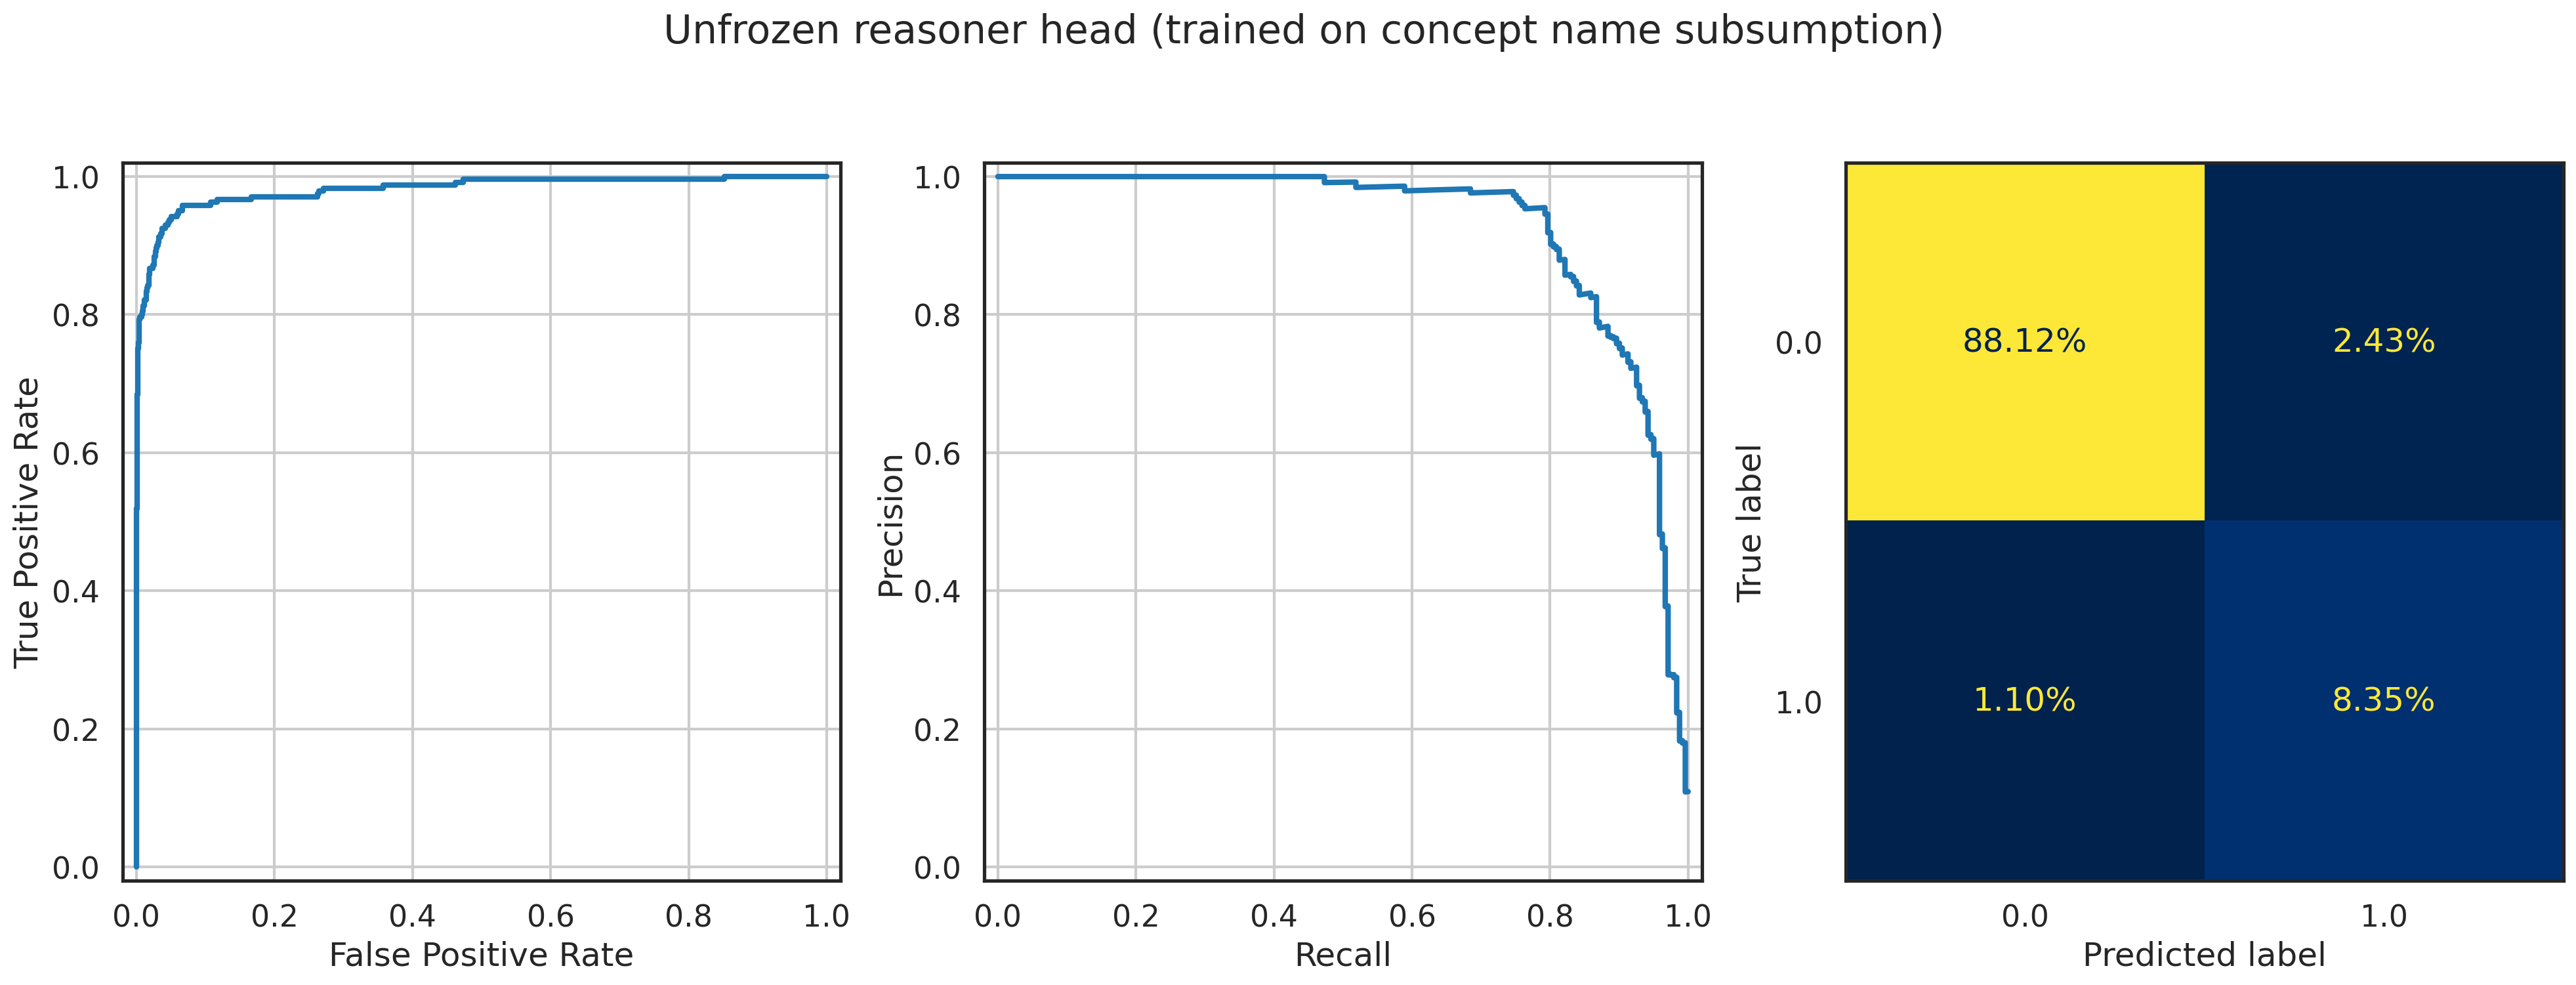

In [9]:
with T.no_grad():
    reasoner.eval()
    _, y_te, Y_te = eval_batch_mod(reasoner.head, [reasoner.embs], X_te, y_te, idx_te)

print(report([onto], y_te, Y_te, idx_te))
plt.suptitle('Unfrozen reasoner head (trained on concept name subsumption)')
plt.show()

In [10]:
from random import random

In [22]:
def all_identities(reasoner, encoders, frozen):
    and_nn = reasoner.and_nn
    bot = reasoner.bot_concept
    top = reasoner.top_concept
    sub_nn =reasoner.sub_nn
    not_nn = reasoner.not_nn

    encoder = encoders[int(np.round(random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random() * (len(encoders) - 1), 0))]
    input2 = encoder.concepts[int(np.round(random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random() * (len(encoders) - 1), 0))]
    input3 = encoder.concepts[int(np.round(random() * encoder.n_concepts, 0) - 1)]
    loss=0
    # # A ⊓ A = A
    # loss = F.mse_loss(input1, and_nn(im_mod(input1, input1)))
    # loss += F.mse_loss(input2, and_nn(im_mod(input2, input2)))
    # loss += F.mse_loss(input3, and_nn(im_mod(input3, input3)))

    # # A ⊓ (B ⊓ C) = (A ⊓ B) ⊓ C 
    # loss += F.mse_loss(and_nn(im_mod(input1, and_nn(im_mod(input2, input3)))), and_nn(im_mod(and_nn(im_mod(input1, input2)), input3)))
    # loss += F.mse_loss(and_nn(im_mod(input2, and_nn(im_mod(input1, input3)))), and_nn(im_mod(and_nn(im_mod(input1, input2)), input3)))
    # loss += F.mse_loss(and_nn(im_mod(input3, and_nn(im_mod(input1, input2)))), and_nn(im_mod(and_nn(im_mod(input3, input2)), input1)))

    # # A ⊓ B = B ⊓ A
    # loss += F.mse_loss(and_nn(im_mod(input1, input3)), and_nn(im_mod(input3, input1)))
    # loss += F.mse_loss(and_nn(im_mod(input3, input2)), and_nn(im_mod(input2, input3)))
    # loss += F.mse_loss(and_nn(im_mod(input2, input1)), and_nn(im_mod(input1, input2)))

    # # ⊥ = A ⊓ ¬A
    # loss += F.mse_loss(bot[0], and_nn(im_mod(input1, not_nn(input1))))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(input2, not_nn(input2))))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(input3, not_nn(input3))))

    # loss += F.mse_loss(bot[0], and_nn(im_mod(not_nn(input1), input1)))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(not_nn(input2), input2)))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(not_nn(input3),input3)))

    # A = A ⊓ T
    # loss += F.mse_loss(input1, and_nn(im_mod(input1, top[0])))*2
    # loss += F.mse_loss(input1, and_nn(im_mod(input2, top[0])))*2
    # loss += F.mse_loss(input3, and_nn(im_mod(input3, top[0])))*2

    # loss += F.mse_loss(input2, and_nn(im_mod(top[0], input1)))*2
    # loss += F.mse_loss(input2, and_nn(im_mod(top[0], input2)))*2
    # loss += F.mse_loss(input2, and_nn(im_mod(top[0], input3)))*2

    # # ⊥ = A ⊓ ⊥
    # loss += F.mse_loss(bot[0], and_nn(im_mod(input1, bot[0])))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(input2, bot[0])))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(input3, bot[0])))

    # loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0], input1)))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0], input2)))
    # loss += F.mse_loss(bot[0], and_nn(im_mod(bot[0], input3)))

    # if not frozen:
    #     loss += F.mse_loss(bot[0], and_nn(im_mod(top[0], bot[0])))

    #  A ⊑ T -> True
    loss += (1 - T.sigmoid(sub_nn(im_mod(input1, top[0])))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input2, top[0])))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input3, top[0])))).sum()
    if not frozen:
        loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], top[0])))).sum()

    #  ⊥ ⊑ A -> True
    loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], input1)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], input2)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], input3)))).sum()

    #  A ⊑ A -> True
    loss += (1 - T.sigmoid(sub_nn(im_mod(input1, input1)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input2, input2)))).sum()
    loss += (1 - T.sigmoid(sub_nn(im_mod(input3, input3)))).sum()

    #  ⊥ = ¬T  
    if not frozen:
        loss += F.l1_loss(bot[0], not_nn(top[0]))
    #  T = ¬⊥
        loss += F.l1_loss(top[0], not_nn(bot[0]))

    #  A = ¬(¬(A))
    loss += F.mse_loss(input1, not_nn(not_nn(input1)))
    loss += F.mse_loss(input2, not_nn(not_nn(input2)))
    loss += F.mse_loss(input3, not_nn(not_nn(input3)))
    if not frozen:
        loss += F.l1_loss(T.matmul(not_nn.weight, not_nn.weight), T.eye(not_nn.weight.shape[1])) * 13
    
    #  ⊥ ⊑ ⊥ -> True
    if not frozen:
        loss += (1 - T.sigmoid(sub_nn(im_mod(bot[0], bot[0])))).sum()

    return loss


all_identities(reasoner.head ,[reasoner.embs], False)

tensor(0.0150, grad_fn=<AddBackward0>)

In [12]:
from random import random

input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]
print(input)
print(reasoner.head.and_nn(im_mod( input, input)))
F.l1_loss(input, reasoner.head.and_nn(im_mod(input, input)))

tensor([-0.0525,  0.2466, -0.1556,  0.0929, -0.0107,  0.3343,  0.1591,  0.2126,
        -0.1443,  0.3194], grad_fn=<SelectBackward0>)
tensor([-0.0272,  0.2560, -0.1930,  0.1331, -0.1303,  0.2506,  0.1367,  0.1564,
         0.0210,  0.1799], grad_fn=<AddBackward0>)


tensor(0.0699, grad_fn=<L1LossBackward0>)

In [13]:
input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.bot_concept[0])
print(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)))
print(F.l1_loss(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)), reasoner.head.bot_concept[0]))

tensor([ 0.2530, -0.2007,  0.1763,  0.1849,  0.1531, -0.0951, -0.3276,  0.0359,
         0.3209, -0.2848], grad_fn=<SelectBackward0>)
tensor([ 0.2594, -0.2024,  0.1893,  0.1946,  0.1678, -0.1051, -0.3211,  0.0433,
         0.3203, -0.2883], grad_fn=<AddBackward0>)
tensor(0.0073, grad_fn=<L1LossBackward0>)


In [14]:
input = T.rand(10)

print(input)
print(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)))
print(F.l1_loss(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)), input))


tensor([0.1273, 0.2256, 0.0086, 0.9971, 0.6375, 0.4530, 0.8606, 0.7849, 0.4546,
        0.4171])
tensor([0.0756, 0.0392, 0.0507, 0.4205, 0.2431, 0.1641, 0.2376, 0.2469, 0.1724,
        0.2253], grad_fn=<AddBackward0>)
tensor(0.3175, grad_fn=<L1LossBackward0>)


In [15]:
input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.bot_concept[0])
output = reasoner.head.and_nn(im_mod(reasoner.head.not_nn(input), input))
print(output)
print(F.l1_loss(output, input))


tensor([ 0.2530, -0.2007,  0.1763,  0.1849,  0.1531, -0.0951, -0.3276,  0.0359,
         0.3209, -0.2848], grad_fn=<SelectBackward0>)
tensor([ 0.2435, -0.2086,  0.1684,  0.1748,  0.1343, -0.1223, -0.3056,  0.0252,
         0.3251, -0.2643], grad_fn=<AddBackward0>)
tensor(0.2594, grad_fn=<L1LossBackward0>)


In [16]:
print(reasoner.head.bot_concept[0])
output = reasoner.head.not_nn(reasoner.head.top_concept[0])
print(output)
print(F.mse_loss(reasoner.head.bot_concept[0], output))

tensor([ 0.2530, -0.2007,  0.1763,  0.1849,  0.1531, -0.0951, -0.3276,  0.0359,
         0.3209, -0.2848], grad_fn=<SelectBackward0>)
tensor([ 0.2528, -0.2009,  0.1763,  0.1846,  0.1526, -0.0950, -0.3275,  0.0359,
         0.3212, -0.2844], grad_fn=<SqueezeBackward3>)
tensor(9.4288e-08, grad_fn=<MseLossBackward0>)


In [17]:
print(reasoner.head.top_concept[0])
output = reasoner.head.not_nn(reasoner.head.bot_concept[0])
print(output)
print(F.mse_loss(reasoner.head.top_concept[0], output))

tensor([-0.2872, -0.0487,  0.1400, -0.0192,  0.1142,  0.2242,  0.3256, -0.0964,
        -0.4799,  0.5422], grad_fn=<SelectBackward0>)
tensor([-0.2871, -0.0484,  0.1405, -0.0194,  0.1139,  0.2238,  0.3255, -0.0966,
        -0.4800,  0.5428], grad_fn=<SqueezeBackward3>)
tensor(1.1693e-07, grad_fn=<MseLossBackward0>)


In [18]:
input1 = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]
input2 = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.and_nn(im_mod(input2,input1)))
print(reasoner.head.and_nn(im_mod(input1,input2)))

F.mse_loss(reasoner.head.and_nn(im_mod(input2,input1)) , reasoner.head.and_nn(im_mod(input1,input2)))

tensor([ 0.2865, -0.0698, -0.0480, -0.1726, -0.1881,  0.0461, -0.0945, -0.2300,
        -0.1344, -0.1858], grad_fn=<AddBackward0>)
tensor([ 0.2795, -0.0588, -0.0367, -0.1742, -0.1969,  0.0355, -0.1043, -0.2313,
        -0.1305, -0.1716], grad_fn=<AddBackward0>)


tensor(8.0320e-05, grad_fn=<MseLossBackward0>)

In [23]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te_2 = np.array(Y_te)
y_te_2 = np.array(y_te)
X_te_2 = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te_2 - y_te_2) > 0.5

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te_2[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rekord': np.arange(len(X_te_2))[błędne_predykcje],
    'Prawdziwa Etykieta': y_te_2[błędne_predykcje],
    'Predykcja': Y_te_2[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'Feature_{i}' for i in range(X_te_2.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)

print(wyniki)

    Rekord  Prawdziwa Etykieta     Predykcja  Feature_0  Feature_1  Feature_2
0       48                 1.0  5.521351e-14          0          6         82
1       61                 0.0  9.873475e-01          0         37         80
2       64                 0.0  9.511847e-01          0          4         18
3       68                 0.0  9.501859e-01          0         95         48
4       73                 0.0  9.782713e-01          0         32         26
..     ...                 ...           ...        ...        ...        ...
85    2451                 0.0  6.369688e-01          0          6         83
86    2466                 0.0  5.355121e-01          0          3         26
87    2474                 1.0  2.379857e-02          0         88         62
88    2528                 0.0  9.300051e-01          0         70         10
89    2546                 0.0  9.217858e-01          0         68         39

[90 rows x 6 columns]


In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(wyniki)

    Rekord  Prawdziwa Etykieta     Predykcja  Feature_0  Feature_1  Feature_2
0       48                 1.0  5.521351e-14          0          6         82
1       61                 0.0  9.873475e-01          0         37         80
2       64                 0.0  9.511847e-01          0          4         18
3       68                 0.0  9.501859e-01          0         95         48
4       73                 0.0  9.782713e-01          0         32         26
5       76                 1.0  2.065600e-01          0         98         96
6       96                 0.0  9.914503e-01          0         11         48
7      106                 1.0  1.050193e-01          0         98         11
8      154                 1.0  3.760704e-01          0         89         97
9      166                 1.0  4.217340e-02          0         55         50
10     186                 0.0  9.763017e-01          0         43         16
11     190                 0.0  9.684263e-01          0         

In [21]:

print(T.round( T.matmul( reasoner.head.not_nn.weight,reasoner.head.not_nn.weight) *100)/100)

tensor([[1., -0., -0., -0., -0., 0., 0., 0., -0., -0.],
        [-0., 1., -0., 0., -0., -0., -0., -0., 0., 0.],
        [-0., -0., 1., 0., 0., 0., 0., -0., 0., -0.],
        [0., -0., -0., 1., -0., -0., -0., 0., -0., 0.],
        [-0., -0., 0., -0., 1., -0., 0., -0., -0., -0.],
        [0., 0., 0., -0., -0., 1., -0., 0., 0., 0.],
        [0., -0., 0., -0., -0., -0., 1., -0., 0., 0.],
        [0., -0., -0., 0., 0., 0., 0., 1., -0., -0.],
        [-0., -0., -0., 0., 0., 0., -0., 0., 1., -0.],
        [-0., 0., -0., 0., -0., -0., 0., -0., 0., 1.]], grad_fn=<DivBackward0>)
